# Model Iteration 2
In this notebook I explore several model types as inspired by resources which will be cited throughout.

In my first iteration, I was able to achieve a score of just over 78%. In this first run of trying different model types, I complete the DataQuest tutorial on random forests. 

In [342]:
#First, let's upload everything, get the data sets to 
#some level of functionality

import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import re
import operator
%matplotlib inline

titanic_master = pd.read_csv('data/train.csv', dtype={'Age':np.float64})
test_data = pd.read_csv('data/test.csv', dtype={'Age':np.float64})

#now for filling in the missing data in the two datasets
titanic_master['Age'] = titanic_master['Age'].fillna(titanic_master['Age'].median())
titanic_master['Fare'] = titanic_master['Fare'].fillna(titanic_master['Fare'].median())
titanic_master.loc[titanic_master['Sex'] == 'male', 'Sex'] = 0
titanic_master.loc[titanic_master['Sex'] == 'female', 'Sex'] = 1
titanic_master['Embarked'] = titanic_master['Embarked'].fillna('S')
titanic_master.loc[titanic_master['Embarked'] == 'S', 'Embarked'] = 0
titanic_master.loc[titanic_master['Embarked'] == 'C', 'Embarked'] = 1
titanic_master.loc[titanic_master['Embarked'] == 'Q', 'Embarked'] = 2

test_data['Age'] = test_data['Age'].fillna(titanic_master['Age'].median())
test_data['Fare'] = test_data['Fare'].fillna(titanic_master['Fare'].median())
test_data.loc[test_data['Sex'] == 'male', 'Sex'] = 0
test_data.loc[test_data['Sex'] == 'female', 'Sex'] = 1
test_data['Embarked'] = test_data['Embarked'].fillna('S')
test_data.loc[test_data['Embarked'] == 'S', 'Embarked'] = 0
test_data.loc[test_data['Embarked'] == 'C', 'Embarked'] = 1
test_data.loc[test_data['Embarked'] == 'Q', 'Embarked'] = 2

In [343]:
#now, to get into the suggestions from Dataquest...
predictors = ['Pclass','Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=4, min_samples_leaf=2)
kf = cross_validation.KFold(titanic_master.shape[0], n_folds=3, random_state=1)
scores = cross_validation.cross_val_score(alg,titanic_master[predictors],titanic_master['Survived'],cv=3)
print scores.mean()          

0.820426487093


In [344]:
#I'm going to pause here and actually just apply this to the test data and submit this.
alg.fit(titanic_master[predictors], titanic_master['Survived'])
predictions = alg.predict_proba(test_data[predictors].astype(float))[:,1]

predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

final_pred = []
for element in predictions:
    final_pred.append(int(element))

submission = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived':final_pred})
submission.to_csv('kaggle_v2_randforest.csv', index=False)

This random forest implementation achieves a score of 0.76077, which is not as compelling as I was able to achieve in my first model iteration. Thinking further ahead (and as suggested by the Dataquest tutorial as well as [this blog](http://elenacuoco.altervista.org/blog/archives/1195) I create different data types to explore.

In [345]:
#family size
titanic_master['Famsize'] = titanic_master['SibSp'] + titanic_master['Parch']
test_data['Famsize'] = test_data['SibSp'] + test_data['Parch']

#family size, including the individual
titanic_master['Count_Individ'] = titanic_master['Famsize'] + 1
test_data['Count_Individ'] = test_data['Famsize'] + 1

#name length 
titanic_master['Namelen'] = titanic_master['Name'].apply(lambda x: len(x))
test_data['Namelen'] = test_data['Name'].apply(lambda x: len(x))

#age groups
titanic_master['Agecat']= titanic_master['Age']
titanic_master.loc[(titanic_master.Age <= 10), 'Agecat'] = 1 #child
titanic_master.loc[(titanic_master.Age > 60), 'Agecat'] = 4 #senior
titanic_master.loc[(titanic_master.Age > 10) & (titanic_master.Age <= 30), 'Agecat'] = 2 #young adult
titanic_master.loc[(titanic_master.Age > 30) & (titanic_master.Age <= 60), 'Agecat'] = 3 #adult
test_data['Agecat']= test_data['Age']
test_data.loc[(test_data.Age <= 10), 'Agecat'] = 1
test_data.loc[(test_data.Age > 60), 'Agecat'] = 4
test_data.loc[(test_data.Age > 10) & (test_data.Age <= 30), 'Agecat'] = 2
test_data.loc[(test_data.Age > 30) & (test_data.Age <= 60), 'Agecat'] = 3

#cabin indicator (as seen in blog post)
titanic_master.loc[titanic_master.Cabin.isnull()==True,'Cabin'] = 0.5
titanic_master.loc[titanic_master.Cabin.isnull()==False,'Cabin'] = 1.
test_data.loc[test_data.Cabin.isnull()==True,'Cabin'] = 0.5
test_data.loc[test_data.Cabin.isnull()==False,'Cabin'] = 1.

#wealth and sex
titanic_master['ClassSex'] = titanic_master['Sex'] * titanic_master['Pclass']
test_data['ClassSex'] = test_data['Sex'] * titanic_master['Pclass']

#age and sex
titanic_master['AgeSex'] = titanic_master['Age'] * titanic_master['Sex']
test_data['AgeSex'] = test_data['Age'] * test_data['Sex']

In [346]:
#title
def get_title(name):
    title_search = re.search('([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

def replace_titles(x):
    title = x['Title']
    if title in ['Mr', 'don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Master']:
        return 'Master'
    elif title in ['Mlle', 'Ms', 'Miss', 'Lady']:
        return 'Miss'
    elif title in ['Countess', 'Mme', 'Mrs', 'Dona']:
        return 'Mrs'
    elif title == 'Dr':
        if x['Sex'] == 0:
            return 'Mr'
        else:
            return 'Mrs'
    elif title == '':
        if x['Sex'] == 0:
            return 'Master'
        else:
            return 'Miss'
    else:
        return title


titles = titanic_master['Name'].apply(get_title)
title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Dr': 5, 'Rev': 6, 'Major': 7, 'Col': 7, 'Mlle': 8, 'Mme': 8, 'Don': 9, 'Lady': 10, 'Countess': 10, 'Jonkheer': 10, 'Sir': 9, 'Capt': 7, 'Ms': 2, 'Dona':10}
for k,v in title_mapping.items():
    titles[titles == k] = v
titanic_master['Title'] = titles    
titanic_master['Title'] = titanic_master.apply(replace_titles, axis=1)

test_titles = test_data['Name'].apply(get_title)
title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Dr': 5, 'Rev': 6, 'Major': 7, 'Col': 7, 'Mlle': 8, 'Mme': 8, 'Don': 9, 'Lady': 10, 'Countess': 10, 'Jonkheer': 10, 'Sir': 9, 'Capt': 7, 'Ms': 2, 'Dona':10}
for k,v in title_mapping.items():
    test_titles[test_titles == k] = v
test_data['Title'] = test_titles
test_data['Title'] = test_data.apply(replace_titles, axis=1)

In [347]:
#family id
family_id_mapping = {}
def get_family_id(row):
    last_name = row['Name'].split(',')[0]
    family_id = '{0}{1}'.format(last_name, row['Famsize'])
    if family_id not in family_id_mapping:
        if len(family_id_mapping) == 0:
            current_id = 1
        else:
            current_id = (max(family_id_mapping.items(), key=operator.itemgetter(1))[1] + 1)
        family_id_mapping[family_id]=current_id
    return family_id_mapping[family_id]

family_ids = titanic_master.apply(get_family_id, axis=1)
family_ids[titanic_master['Famsize'] < 3] = -1
titanic_master['Familyid'] = family_ids

family_ids = test_data.apply(get_family_id, axis=1)
family_ids[test_data['Famsize'] < 3] = -1
test_data['Familyid'] = family_ids

Now that a bunch of indicators have been added, I want to look over the signal coming from these indicators, and start thinking about the relationships between the strong indicators. I use the approach described in the Dataquest tutorial in order to achieve this. I then apply the model to the testing data in order to see whether there was improvement using this method.

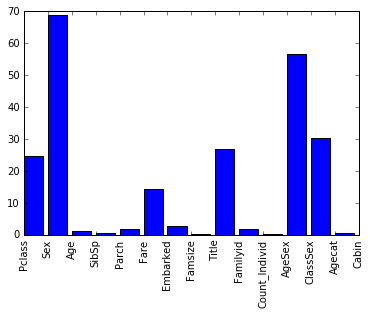

0.81593714927


In [348]:
predictors = ['Pclass','Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked','Famsize', 'Title', 'Familyid', 'Count_Individ', 'AgeSex', 'ClassSex', 'Agecat', 'Cabin']
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic_master[predictors], titanic_master['Survived'])
scores = -np.log10(selector.pvalues_)

plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

best_predictors = ['Pclass', 'Sex', 'Fare', 'Title', 'AgeSex', 'ClassSex']
alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=8, min_samples_leaf=4)
kf = cross_validation.KFold(titanic_master.shape[0], n_folds=3, random_state=1)
scores = cross_validation.cross_val_score(alg,titanic_master[best_predictors],titanic_master['Survived'],cv=3)
print scores.mean() 

#apply to testing data, use best_predictors
alg.fit(titanic_master[best_predictors], titanic_master['Survived'])
predictions = alg.predict_proba(test_data[best_predictors].astype(float))[:,1]

predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

final_pred = []
for element in predictions:
    final_pred.append(int(element))

submission = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived':final_pred})
submission.to_csv('kaggle_v2_randforestimproved.csv', index=False)

Even with this improved random forest, my score still sits at 0.76077. This implies to me that I've distilled some of the fundamental signal using this method, but there is a chance that this method has overfit the data by some amount. Taking a cue from the Dataquest model, I next explore ensembling and gradient boosting in order to pull together different methodologies in order to get a stronger correlation.

In [349]:
#I'll try gradient boosting and a logistic regression in this first pass, with all of the predictors
algos = [[GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), predictors],[LogisticRegression(random_state=1), predictors]]
kf = cross_validation.KFold(titanic_master.shape[0], n_folds=3, random_state=1)

preds = []
for train, test in kf:
    train_tar = titanic_master['Survived'].iloc[train]
    full_test_pred = []
    for alg, predictors in algos:
        alg.fit(titanic_master[predictors].iloc[train,:], train_tar)
        test_preds = alg.predict_proba(titanic_master[predictors].iloc[test,:].astype(float))[:,1]
        full_test_pred.append(test_preds)
    test_preds = (full_test_pred[0]*2 + full_test_pred[1])/3 #this weighs gradient heavily equally
    test_preds[test_preds <= 0.5] = 0
    test_preds[test_preds >0.5] = 1
    preds.append(test_preds)

predictions = np.concatenate(preds, axis=0)
accuracy = sum(predictions[predictions == titanic_master['Survived']])/len(predictions)
print accuracy

0.817059483726


/home/vpreston/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


In [350]:
#for a final submission
final_predictions = []
for alg, predictors in algos:
    alg.fit(titanic_master[predictors], titanic_master['Survived'])
    predictions = alg.predict_proba(test_data[predictors].astype(float))[:,1]
    final_predictions.append(predictions)

predictions = (final_predictions[0] * 2 + final_predictions[1]) / 3
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

final_pred = []
for element in predictions:
    final_pred.append(int(element))

submission = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived':final_pred})
submission.to_csv('kaggle_v2_ensemble1.csv', index=False)

This ensemble brought my score up to 0.78947, which is only a small amount better than my first iteration model score using a simple formula. I now explore improvements to this model, starting with the predictors (namely, narrowing them down to known quantities with signal).

In [351]:
grad_pred = ['Pclass','Sex', 'Age', 'Fare', 'Embarked', 'Title', 'Familyid', 'Famsize', 'ClassSex', 'AgeSex']
log_pred = ['Pclass', 'Sex', 'Fare', 'Title', 'Famsize', 'Age', 'Embarked', 'ClassSex', 'AgeSex']

algos = [[GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), grad_pred],[LogisticRegression(random_state=1), log_pred]]
kf = cross_validation.KFold(titanic_master.shape[0], n_folds=3, random_state=1)

preds = []
for train, test in kf:
    train_tar = titanic_master['Survived'].iloc[train]
    full_test_pred = []
    for alg, predictors in algos:
        alg.fit(titanic_master[predictors].iloc[train,:], train_tar)
        test_preds = alg.predict_proba(titanic_master[predictors].iloc[test,:].astype(float))[:,1]
        full_test_pred.append(test_preds)
    test_preds = (full_test_pred[0] * 3 + full_test_pred[1]) / 4
    test_preds[test_preds <= 0.5] = 0
    test_preds[test_preds >0.5] = 1
    preds.append(test_preds)

predictions = np.concatenate(preds, axis=0)
accuracy = sum(predictions[predictions == titanic_master['Survived']])/len(predictions)
print accuracy

#for test data
final_predictions = []
for alg, predictors in algos:
    alg.fit(titanic_master[predictors], titanic_master['Survived'])
    predictions = alg.predict_proba(test_data[predictors].astype(float))[:,1]
    final_predictions.append(predictions)

predictions = (final_predictions[0] * 3 + final_predictions[1]) / 4
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

final_pred = []
for element in predictions:
    final_pred.append(int(element))

submission = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived':final_pred})
submission.to_csv('kaggle_v2_ensembleimproved.csv', index=False)

0.822671156004


/home/vpreston/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


This indicator adjustment actually got me to the "advertised" accuracy of 0.79904 from the Dataquest experience. Now, I want to explore the relationships I had begun to explore in my first exploration, but now with more advanced categories of data. I draw upon inspiration from the blog post mentioned earlier, however the formula is my own and is based upon the data mining technique covered in ThinkStats.

In [352]:
import statsmodels.formula.api as smf

formula = 'Survived~ClassSex*Age+Fare+Title+Famsize*Pclass+Embarked*Agecat'
model = smf.logit(formula, data=titanic_master)
results = model.fit()

#assess our training
pred = results.predict()
pred[pred >= 0.5] = 1
pred[pred < 0.5] = 0
accuracy = sum(pred[pred == titanic_master['Survived']] / len(pred))
print accuracy

new = test_data
predicts = results.predict(new)

predicts[predicts > 0.5] = int(1)
predicts[predicts <= 0.5] = int(0)

final_pred = []
for element in predicts:
    final_pred.append(int(element))

#now make a submission dataframe for Kaggle
submission = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived':final_pred})
# print submission
submission.to_csv('kaggle_v2_formula.csv', index=False)

Optimization terminated successfully.
         Current function value: 0.409502
         Iterations 8
0.83164983165


/home/vpreston/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


This self-defined model achieved me a score just slightly less than that of the dataquest version, 0.79900. I'm excited that I've seemed to hone in on some of the most powerful relationships using intuition and the "goodness" of the predictors score as achieved earlier. I'm going to define new categories based on some of these powerful relationships and then apply them to an ensembled approach which has given me my best scores yet. I'm also going to make some fare and family relationship joint indicators, as inspired by the blog I've mentioned, as well as try out some decision tree work inspired by [this](https://www.kaggle.com/c/titanic/forums/t/6821/titanic-getting-started-with-r-full-guide-to-0-81340) resource Paul cited in the class.

In [353]:
from sklearn.tree import DecisionTreeRegressor

predictors = best_predictors

regr = DecisionTreeRegressor(max_depth=len(predictors))
kf = cross_validation.KFold(titanic_master.shape[0], n_folds=3, random_state=1)

preds = []
for train, test in kf:
    train_tar = titanic_master['Survived'].iloc[train]
    regr.fit(titanic_master[predictors].iloc[train,:], train_tar)
    test_preds = regr.predict(titanic_master[predictors].iloc[test,:].astype(float))
    test_preds[test_preds >= 0.5] = 1
    test_preds[test_preds < 0.5] = 0
    preds.append(test_preds[0:])

predictions = np.concatenate(preds,axis=0)
accuracy = sum(predictions[predictions == titanic_master['Survived']])/len(predictions)
print accuracy

#on test data
regr.fit(titanic_master[predictors], titanic_master['Survived'])
predicts = regr.predict(test_data[predictors])

predicts[predicts > 0.5] = int(1)
predicts[predicts <= 0.5] = int(0)

final_pred = []
for element in predicts:
    final_pred.append(int(element))

#now make a submission dataframe for Kaggle
submission = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived':final_pred})

# print submission
submission.to_csv('kaggle_v2_decisiontree.csv', index=False)

0.811447811448


/home/vpreston/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


This decision tree implementation recieved a scores of 0.77512. Not bad, but also not an improvement over the Dataquest model. The blog further suggests applying a random forest to the decision trees. Instead, I'm going to try an ensemble of a gradient, logistic, and decision tree in my last attempt at betterng the Dataquest model. This is largely driven by the idea that the decision tree gives some flexibility in a model which performs relatively well.

In [354]:
dtr_pred = best_predictors
grad_pred = ['Pclass','Sex', 'Age', 'Fare', 'Embarked', 'Title', 'Familyid', 'Famsize', 'ClassSex', 'AgeSex']
log_pred = ['Pclass', 'Sex', 'Fare', 'Title', 'Famsize', 'Age', 'Embarked', 'ClassSex', 'AgeSex']
algos = [[DecisionTreeRegressor(max_depth=3),dtr_pred], [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), grad_pred],[LogisticRegression(random_state=1), log_pred]]
kf = cross_validation.KFold(titanic_master.shape[0], n_folds=3, random_state=1)

preds = []
for train, test in kf:
    train_tar = titanic_master['Survived'].iloc[train]
    full_test_pred = []
    for alg, predictors in algos:
        alg.fit(titanic_master[predictors].iloc[train,:], train_tar)
        test_preds = alg.predict(titanic_master[predictors].iloc[test,:].astype(float))
        full_test_pred.append(test_preds)
    test_preds = (full_test_pred[0]*2 + full_test_pred[1] + full_test_pred[2]) / 4
    test_preds[test_preds <= 0.5] = 0
    test_preds[test_preds >0.5] = 1
    preds.append(test_preds)

predictions = np.concatenate(preds,axis=0)
accuracy = sum(predictions[predictions == titanic_master['Survived']])/len(predictions)
print accuracy

#on test data
final_predictions = []
for alg, predictors in algos:
    alg.fit(titanic_master[predictors], titanic_master['Survived'])
    predictions = alg.predict(test_data[predictors].astype(float))
    final_predictions.append(predictions)

predictions = (final_predictions[0] * 2 + final_predictions[1] + final_predictions[2]) / 4
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

final_pred = []
for element in predictions:
    final_pred.append(int(element))

#now make a submission dataframe for Kaggle
submission = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived':final_pred})

# print submission
submission.to_csv('kaggle_v2_decisiontreeensemble.csv', index=False)

0.827160493827


/home/vpreston/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


This final submission bought me a score of 0.80383. This implies to me that the addition of the decision tree to my previous ensemble was valuable. My theory on this matter is that the decision tree offers some amount of implicit weighting to individuals based upon the factors given. This both allows for more variance in the accuracy (which I consider to be good in this case because at about 0.799 it is really only a few values which need to be flipped) and also means that overfitting to the data can be easy. To avoid the overfitting data, I aimed to keep my fold accuracy at about the point which seems to yield the best results on the testing data (just over 80%). More than this number seems to get me data that matches well with the training but poorly with the testing, whereas less gets me...less. 

At the conclusion of this warmup project, I feel that I've had a chance to practice and read more on data cleaning, data mining, formulaic approaches to fitting data, and built-in data fitting packages in scikitlearn. I am also left with a few questions: how does one detext overfitting? is there a way to predict testing accuracy without crossreferncing the answers? what ethodical approach to data scientists typically take to finding and fitting a model to data? how much of data science is being clever (not necessarily being analytical)? 

I enjoyed in this last iteration the ability to explore the concept of ensembles more, and to apply a new technique listed in a class resource on decision trees. The resource expounded on the concept using a programming language R which I abstracted using scikitlearn. I would be curious to see how similar the underlying algorithms are for these two fitting techniques. 